# Задача 1

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm

$Q(w) = \sum\limits_{i=1}^{m}\log{(1 + \exp(-y_i <x_i, w>))}$

$\nabla Q(w) = -\sum\limits_{i=1}^{m}\frac{x_i y_i}{1 + \exp(-y_i  <x_i, w>)}$ ($x_i$ стоит трактовать как вектор, таким образом получим вектор градиентов)

Модель поддерживает шаги:

* Постоянный - параметр learning rate
* Зависящий от номера шага - параметр iter_func
* Правило одномерной минимизации (так как фугкция выпукла, то корректно перебирать тернарным поиском)

In [2]:
class LogisticRegression:
    def __init__(self):
        self.params = None
        self.cur_iter = 0
    
    def fit(self, X, y, threshold=1e-3, max_iter=100, seed=None, iter_func=None, lr=0.01, 
            use_one_side_minimization=False, top_fastest_one_side_border=0.1, top_fastest_one_side_max_steps=10):
        cur_error = None
        self.params = sps.norm().rvs(X.shape[1])
        if seed is not None:
            self.params = seed
        prev_error = None
        while self.cur_iter < max_iter:
            preds = self._predict_degree(X, self.params)
            cur_error = self._loss(preds, y)
            if  prev_error is not None and abs(cur_error - prev_error) < threshold:
                break
            prev_error = cur_error
            gradient = self._gradient(X, preds, y)
            if  use_one_side_minimization:
                gradient *= self._calculate_fastest_one_side(X, y, gradient, top_fastest_one_side_border, 
                                                             threshold, top_fastest_one_side_max_steps)
            elif iter_func is not None:
                gradient *= iter_func(self.cur_iter)
            else:
                gradient *= lr
            self.params -= gradient
            self.cur_iter += 1
        
    def predict(self, X):
        return 1 / (1 + np.exp(-X @ self.params))
        
    def _loss(self, preds, y):
        return np.log(1 + np.exp(-y * preds)).sum()
    
    def _gradient(self, X, preds, y):
        margin = (y * preds)[:, np.newaxis]
        return -(X * y[:, np.newaxis] * np.exp(-margin) / (1 + np.exp(-margin))).sum(0)
    
    def _predict_degree(self, X, params):
        return X @ params
    
    def _calculate_fastest_one_side(self, X, y, gradient, top_fastest_one_side_border, threshold, 
                                    top_fastest_one_side_max_steps):
        left_border = 0
        right_border = top_fastest_one_side_border
        cur_iter = 0
        while cur_iter < top_fastest_one_side_max_steps and right_border - left_border > threshold:
            a = (left_border * 2 + right_border) / 3
            b = (left_border + right_border * 2) / 3
            if self._loss(self._predict_degree(X, self.params - left_border * gradient), y) <\
               self._loss(self._predict_degree(X, self.params - left_border * gradient), y):
                right_border = b
            else:
                left_border = a
            cur_iter += 1
        return (left_border + right_border) / 2

## Посмотрим на работу алгоритма на практике

In [3]:
def generate_data(sample_size=100, dim=2, separable=True):
    X = np.concatenate((-np.ones((sample_size, 1)), sps.uniform(loc=-5, scale=10).rvs((sample_size, dim))), -1)
    if separable:
        hyperplane = sps.uniform(loc=-0.5, scale=1).rvs(dim)
        y = (X[:, 1:] @ hyperplane >= 0).astype(np.int64)
        y[y == 0] = -1
        return X, y, hyperplane
    y = sps.randint(low=0, high=2).rvs(sample_size)
    y[y == 0] = -1
    return X, y

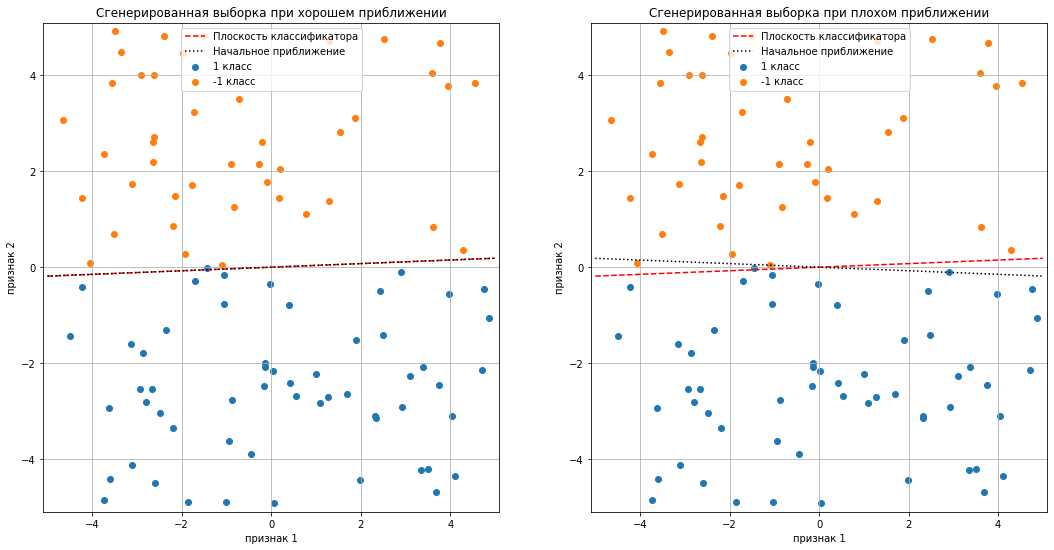

In [4]:
X, y, plane = generate_data()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
for i, ax in enumerate(axs):
    seed = np.array([0.0] + list(plane))
    
    seed_multiplier = 1
    if i == 1:
        seed_multiplier = -1
        seed[-1] = -seed[-1]
    
    classifier = LogisticRegression()
    classifier.fit(X, y, seed=seed)

    grid = np.linspace(-5, 5, 100)
    positive_mask = (y == 1)
    
    ax.scatter(X[positive_mask, 1], X[positive_mask, 2], label='1 класс')
    ax.scatter(X[~positive_mask, 1], X[~positive_mask, 2], label='-1 класс')
    ax.plot(grid, -classifier.params[1] / classifier.params[2] * grid, label='Плоскость классификатора',
             c='r', ls='dashed')
    ax.plot(grid, -seed_multiplier * seed[-2] / seed[-1] * grid, label='Начальное приближение', c='black', ls='dotted')
    ax.legend()
    ax.set_xlim(-5.1, 5.1)
    ax.set_ylim(-5.1, 5.1)
    ax.set_xlabel('признак 1')
    ax.set_ylabel('признак 2')
    ax.set_title('Сгенерированная выборка при {} приближении'.format("плохом" if i == 1 else "хорошем"))
    ax.grid()

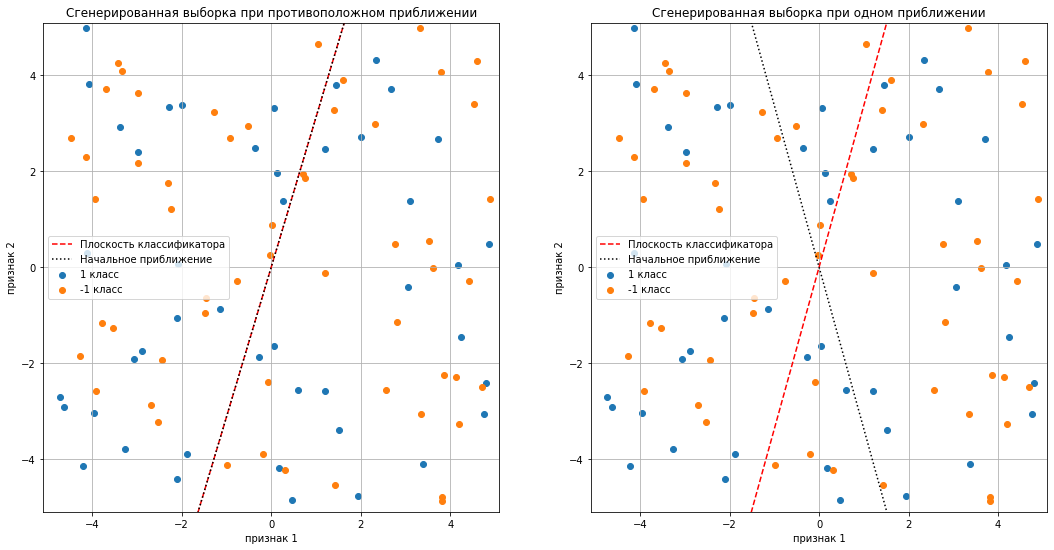

In [5]:
X, y = generate_data(separable=False)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
for i, ax in enumerate(axs):
    seed = np.array([0.0, 1.0, 2.0])
    
    seed_multiplier = 1
    if i == 1:
        seed_multiplier = -1
        seed[-1] = -seed[-1]
    
    classifier = LogisticRegression()
    classifier.fit(X, y, seed=seed)

    grid = np.linspace(-5, 5, 100)
    positive_mask = (y == 1)
    
    ax.scatter(X[positive_mask, 1], X[positive_mask, 2], label='1 класс')
    ax.scatter(X[~positive_mask, 1], X[~positive_mask, 2], label='-1 класс')
    ax.plot(grid, -classifier.params[1] / classifier.params[2] * grid, label='Плоскость классификатора',
             c='r', ls='dashed')
    ax.plot(grid, -seed_multiplier * seed[-2] / seed[-1] * grid, label='Начальное приближение', c='black', ls='dotted')
    ax.legend()
    ax.set_xlim(-5.1, 5.1)
    ax.set_ylim(-5.1, 5.1)
    ax.set_xlabel('признак 1')
    ax.set_ylabel('признак 2')
    ax.set_title('Сгенерированная выборка при {} приближении'.format("одном" if i == 1 else "противоположном"))
    ax.grid()

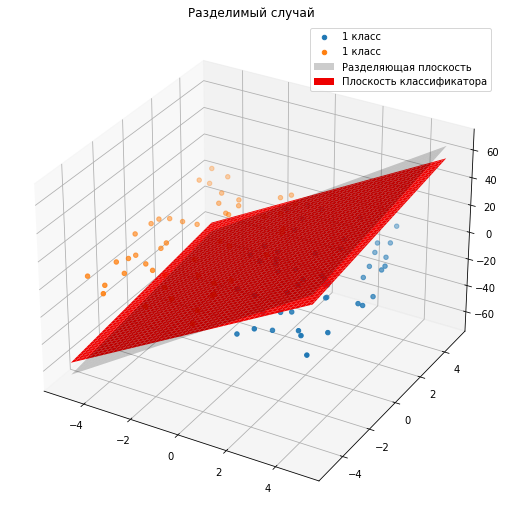

In [30]:
X, y, plane = generate_data(dim=3)
classifier = LogisticRegression()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Разделяющая плоскость', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.title('Разделимый случай')
plt.legend()
plt.show()

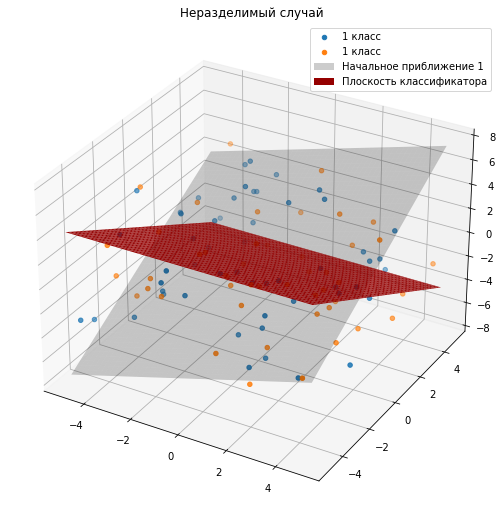

In [39]:
X, y = generate_data(dim=3, separable=False)
classifier = LogisticRegression()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Начальное приближение 1', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.legend()
plt.title('Неразделимый случай')
plt.show()

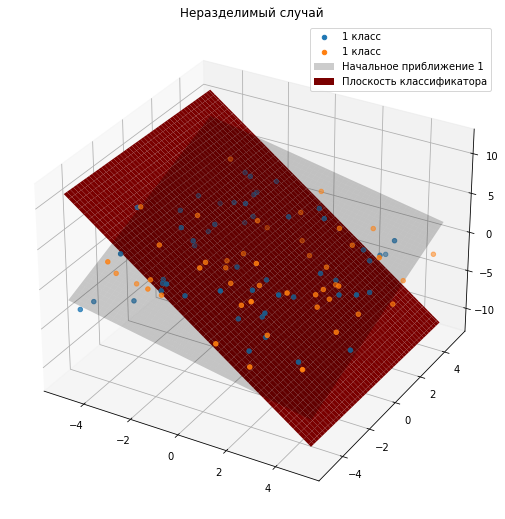

In [40]:
plane[0] *= -1
classifier = LogisticRegression()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Начальное приближение 1', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.legend()
plt.title('Неразделимый случай')
plt.show()

**Вывод:** алгоритм работает, прекрасно разделяя классы между собой, если они разделимы. В обеих случаях если выборки линейно разделимы, то начальное приближение большой роли не играет, но если неразделимы, то ответы могут меняться в зависимости от приближения

## Посмотрим на скорость сходимости алгоритмов

In [7]:
def train_and_get_iter_cnt(X, y, epsillon, **kwargs):
    # для того, чтобы приближения были одинаковы каждый раз
    np.random.seed(seed=42)
    classifier = LogisticRegression()
    classifier.fit(X, y, max_iter=float('inf'), threshold=epsillon, **kwargs)
    return classifier.cur_iter

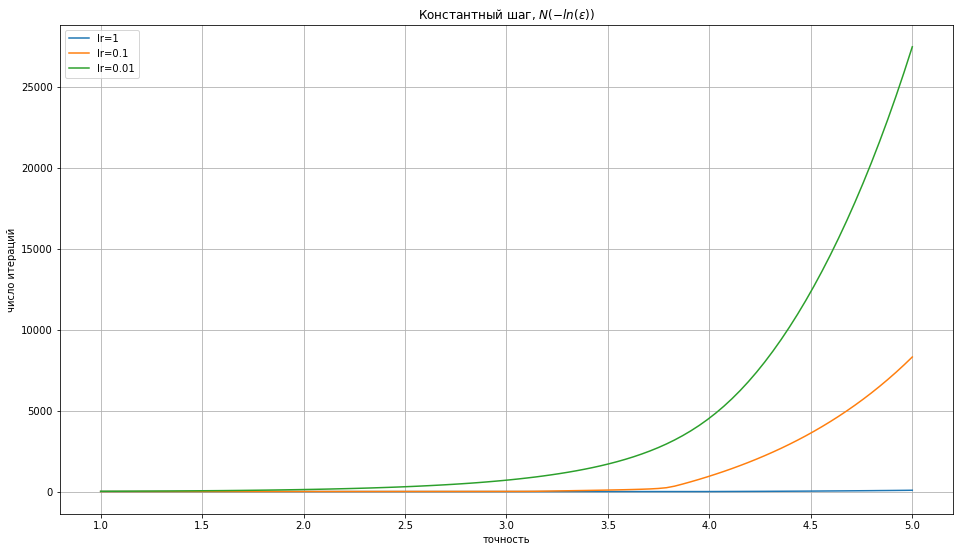

In [44]:
plt.figure(figsize=(16, 9))
X, y, plane = generate_data()
epsillon_grid = 10 ** -np.linspace(1, 5, 100)

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=1)
iters1 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters1, label='lr=1')

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=0.1)
iters01 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters01, label='lr=0.1')

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=0.01)
iters001 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters001, label='lr=0.01')
plt.grid()
plt.title('Константный шаг, $N(-ln(\epsilon))$')
plt.legend()
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.show()

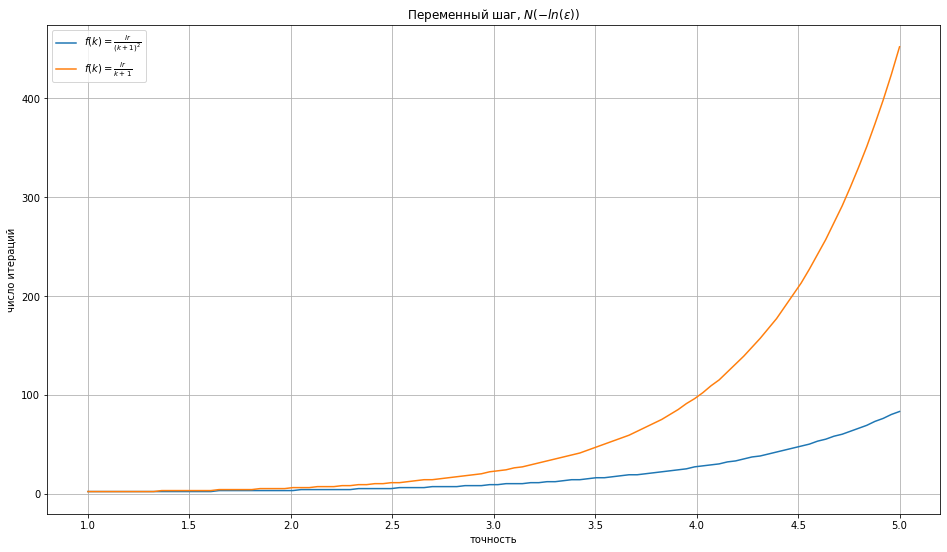

In [47]:
plt.figure(figsize=(16, 9))
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, iter_func=lambda k: 0.1/(k+1)**2)
iters_sqr = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters_sqr, label=r'$f(k)=\frac{lr}{(k+1)^2}$')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, iter_func=lambda k: 0.1/(k+1))
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'$f(k)=\frac{lr}{k+1}$')
plt.grid()
plt.title('Переменный шаг, $N(-ln(\epsilon))$')
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.legend()
plt.show()

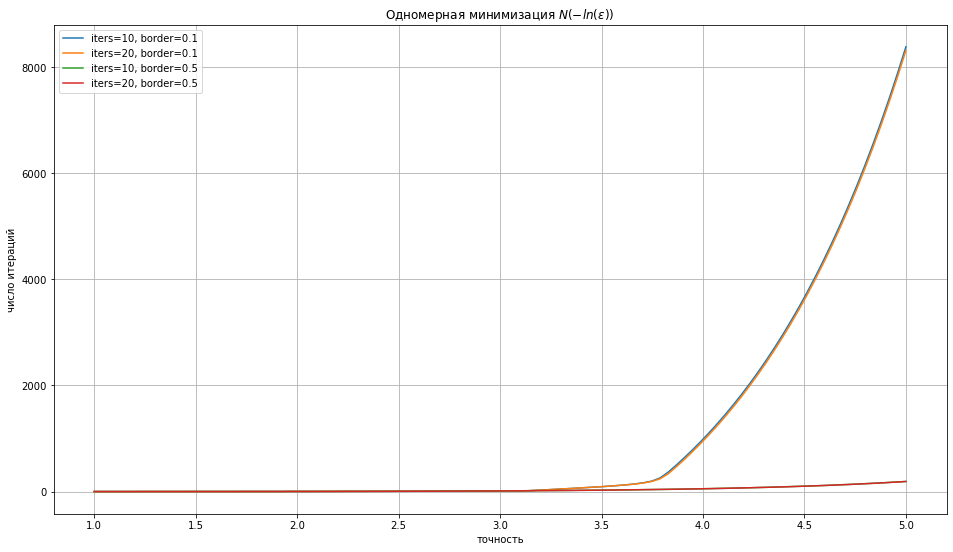

In [46]:
plt.figure(figsize=(16, 9))
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=10, border=0.1')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=20)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=20, border=0.1')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=10, top_fastest_one_side_border=0.5)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=10, border=0.5')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=20, top_fastest_one_side_border=0.5)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=20, border=0.5')
plt.grid()
plt.title('Одномерная минимизация $N(-ln(\epsilon))$')
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.legend()
plt.show()

**Вывод:** видим, что в случае с нашей задачей увеличение learning rate (до рассмотренного значения) приводит к увеличению скорости сходимости метода. Метод с перемнным шагом работает быстрее константного с тем же learning rate, это происходит потому что с увеличением необходимой точности, как правило, нужно вносить меньшие значения в параметры и уменьшенный размер шага помогает в этом. Метод одномерной минимизации работает заметно лучше метода с аналогичным lr.